## Installation

In [78]:
!pip install hazm
!pip install parsivar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached nltk-3.3-py3-none-any.whl
  Attempting uninstall: nltk
    Found existing installation: nltk 3.4.5
    Uninstalling nltk-3.4.5:
      Successfully uninstalled nltk-3.4.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
parsivar 0.2.3 requires nltk==3.4.5, but you have nltk 3.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached nltk-3.4.5-py3-none-any.whl
  Attempting uninstall: nltk
    Found existing installation: nltk 3.3
    Uninstalling nltk-3.3:
      Successfully uninstalled nltk-3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
hazm

In [79]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## PHASE 1

### Reading data

In [80]:
import json

In [81]:
def read_json(path):
  file = open(path)
  data = json.load(file)
  return data

In [82]:
input_data = read_json('/content/drive/MyDrive/IR_data_news_12k.json')

In [83]:
print(list(input_data.values())[0])

{'title': 'اعلام زمان قرعه کشی جام باشگاه های فوتسال آسیا', 'content': '\nبه گزارش خبرگزاری فارس، کنفدراسیون فوتبال آسیا (AFC) در نامه ای رسمی به فدراسیون فوتبال ایران و باشگاه گیتی پسند زمان\xa0 قرعه کشی جام باشگاه های فوتسال آسیا را رسماً اعلام کرد. بر این اساس 25 فروردین ماه 1401 مراسم قرعه کشی جام باشگاه های فوتسال آسیا در مالزی برگزار می شود. باشگاه گیتی پسند بعنوان قهرمان فوتسال ایران در سال 1400 به این مسابقات راه پیدا کرده است. پیش از این گیتی پسند تجربه 3 دوره حضور در جام باشگاه های فوتسال آسیا را داشته که هر سه دوره به فینال مسابقات راه پیدا کرده و یک عنوان قهرمانی و دو مقام دومی بدست آورده است. انتهای پیام/\n\n\n', 'tags': ['اعلام زمان', 'قرعه\u200cکشی', 'قرعه\u200cکشی جام', 'قرعه\u200cکشی جام باشگاه\u200cهای فوتسال', 'ای اف سی', 'گیتی پسند'], 'date': '3/15/2022 5:59:27 PM', 'url': 'https://www.farsnews.ir/news/14001224001005/اعلام-زمان-قرعه-کشی-جام-باشگاه-های-فوتسال-آسیا', 'category': 'sports'}


In [84]:
print(list(input_data.values())[0].keys())

dict_keys(['title', 'content', 'tags', 'date', 'url', 'category'])


In [85]:
contents = [input_data[i]['content'] for i in input_data]

In [86]:
print(len(contents))

12202


In [87]:
print(contents[0])


به گزارش خبرگزاری فارس، کنفدراسیون فوتبال آسیا (AFC) در نامه ای رسمی به فدراسیون فوتبال ایران و باشگاه گیتی پسند زمان  قرعه کشی جام باشگاه های فوتسال آسیا را رسماً اعلام کرد. بر این اساس 25 فروردین ماه 1401 مراسم قرعه کشی جام باشگاه های فوتسال آسیا در مالزی برگزار می شود. باشگاه گیتی پسند بعنوان قهرمان فوتسال ایران در سال 1400 به این مسابقات راه پیدا کرده است. پیش از این گیتی پسند تجربه 3 دوره حضور در جام باشگاه های فوتسال آسیا را داشته که هر سه دوره به فینال مسابقات راه پیدا کرده و یک عنوان قهرمانی و دو مقام دومی بدست آورده است. انتهای پیام/





### Preprocessing

In [88]:
from parsivar import Normalizer, Tokenizer, FindStems
from hazm import stopwords_list

In [89]:
normalizer = Normalizer()
tokenizer = Tokenizer()
stemmer = FindStems()

In [90]:
stopwords = {stopwords_list()[i] for i in range(0, len(stopwords_list()) - 1)}
extra_stopwords = ['،', '.', ')', '(', '}', '{', '«', '»', '؛', ':',  '؟','>','<','|','+','-','*',"^",'%','#','=','_','/','«','»','$','[',']','&',"❊",'«','»']
stopwords.update(extra_stopwords)

In [91]:
def preprocess(contents, rm_sw=True, stemming=True):
  preprocessed_docs = []
  for content in contents:
    
    # normalizing
    normalized_content = normalizer.normalize(content)
    content_tokens = tokenizer.tokenize_words(normalized_content)
    tokens = []
    for token in content_tokens:
      # stemming
      if stemming:
        token = stemmer.convert_to_stem(token)
      # remove stopwords
      if rm_sw:
          if token in stopwords:
                continue
      tokens.append(token)
    preprocessed_docs.append(tokens)
    # tokens of each doc
  return preprocessed_docs



In [92]:
preprocessed_docs = preprocess(contents)

In [93]:
print(len(preprocessed_docs))

12202


### Positional indexing

In [94]:
class Term:
    def __init__(self):
        self.total_freq = 0
        self.pos_in_doc = {} 
        self.freq_in_doc = {}
        self.weight_in_doc = {}
        self.champ_list = {}

    def update_posting(self, doc_id, term_position):
      if doc_id not in self.pos_in_doc:
            self.pos_in_doc[doc_id] = []
            self.freq_in_doc[doc_id] = 0
      self.pos_in_doc[doc_id].append(term_position)
      self.freq_in_doc[doc_id] += 1
      self.total_freq += 1
    
    def get_docs(self):
      return self.pos_in_doc.keys()
    
    def get_weight_in_doc(self, doc_id):
      return self.weight_in_doc[doc_id]
    
    def calc_weight(self, doc_id, collection_size):
      self.weight_in_doc [doc_id] = calculate_tf_idf(self, doc_id, collection_size)
    
    def create_champ_list(self, r):
      self.champ_list = dict(sorted(self.weight_in_doc.items(), key=lambda item: item[1], reverse=True)[:r])

    def get_champ_list(self):
      return self.champ_list

In [95]:
def positional_indexing(preprocessed_docs):
    p_inv_index = {} 
    for doc_id in range(len(preprocessed_docs)):
        for pos in range(len(preprocessed_docs[doc_id])):
            term = preprocessed_docs[doc_id][pos]
            if term in p_inv_index:
                term_obj = p_inv_index[term]
            else:
                term_obj = Term()
            term_obj.update_posting(doc_id, pos)
            p_inv_index[term] = term_obj

    return p_inv_index

In [96]:
positional_index = positional_indexing(preprocessed_docs)

In [97]:
print(positional_index['فوتبال'].pos_in_doc)

{0: [4, 10], 1: [27, 34], 2: [34], 3: [17, 38, 64, 75, 97, 119, 145], 7: [8], 9: [35], 12: [6, 48], 15: [6], 16: [6, 14], 23: [31, 67], 29: [13, 209], 33: [4, 9, 25, 43], 35: [4, 32], 36: [15, 27], 37: [6, 15], 40: [101], 42: [34], 45: [22], 48: [303], 53: [56, 200, 235, 246, 282, 283, 419], 63: [34], 64: [75], 66: [12, 37, 90, 184, 213], 69: [8, 34], 74: [9], 76: [57], 79: [18], 80: [9, 35, 85], 81: [11, 45, 46, 73, 86, 96, 99, 104, 115, 119, 134, 141, 164], 82: [15], 84: [37], 85: [11, 26, 70, 89, 139, 183, 248, 355, 367], 86: [210, 553], 87: [5, 49], 88: [12], 89: [10, 110, 207, 264, 282, 328, 397, 401, 410, 420], 90: [4], 91: [273], 94: [10], 95: [47], 96: [16, 31, 48], 97: [5], 102: [10], 103: [4], 104: [104], 107: [8], 109: [9], 112: [40], 113: [8], 115: [8], 120: [23, 31, 51, 73], 123: [10], 127: [4, 13, 26], 128: [124], 129: [30, 31, 54, 58, 72, 91, 112, 117, 122], 134: [33, 98, 104, 116, 125, 130, 147, 161], 136: [7, 27, 47], 137: [6, 23, 25, 40, 42], 138: [6, 11, 18], 139: [6

In [98]:
preprocessed_docs[6]

['گزارش',
 'خبرگزاری',
 'فارس',
 'نقل',
 'سایت',
 'باشگاه',
 'پرسپولیس',
 'خبری',
 'مسابقه',
 'سرمربی',
 'تیم',
 'پرسپولیس',
 'استقلال',
 'هفته',
 'بیست',
 'لیگ',
 'برتر',
 'جام',
 'خلیج\u200cفارس',
 'مدیریت',
 'سازمان',
 'لیگ',
 'هماهنگی',
 'باشگاه',
 'میزبان',
 'پرسپولیس',
 'ورزشگاه',
 'شهید',
 'کاظمی',
 'شرح',
 'برگزار',
 'شد&شو',
 'چهارشنبه',
 '25',
 'اسفند',
 'ساعت',
 '13',
 'فرهاد',
 'مجیدی',
 'سرمربی',
 'استقلال',
 'ساعت',
 '13',
 '30',
 'یحیی',
 'گل',
 'محمدی',
 'سرمربی',
 'پرسپولیس',
 'مسابقه',
 'تیم',
 'روز',
 'پنجشنبه',
 'ورزشگاه',
 'آزادی',
 'برگزار',
 'شد&شو',
 'گزارش',
 'خبرگزاری',
 'فارس',
 'باشگاه',
 'استقلال',
 'اعلام',
 'کرد&کن',
 'قرار',
 'اس',
 'خبری',
 'فرهاد',
 'مجیدی',
 'سرمربی',
 'تیم',
 'ساعت',
 '15',
 'سازمان',
 'لیگ',
 'برگزار',
 'شد&شو',
 'انتهای',
 'پیام']

In [99]:
print(positional_index['گزارش'].freq_in_doc)

{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 2, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 2, 18: 1, 19: 3, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 3, 26: 1, 28: 3, 30: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 65: 1, 66: 1, 67: 1, 68: 2, 69: 1, 70: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 2, 77: 2, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1, 100: 1, 101: 1, 102: 1, 103: 1, 105: 1, 106: 1, 107: 1, 108: 1, 109: 2, 110: 1, 111: 1, 112: 2, 113: 1, 114: 1, 115: 1, 116: 1, 117: 1, 118: 1, 119: 1, 120: 1, 121: 1, 122: 1, 123: 1, 124: 2, 125: 1, 126: 2, 127: 1, 129: 1, 130: 1, 131: 2, 132: 1, 133: 1, 134: 3, 135: 1, 136: 1, 137: 1, 138: 1, 139: 1, 140: 1, 141: 1, 142: 1, 143: 1, 144: 1, 145: 1, 146: 1, 147: 

In [100]:
# check the value of total_freq is correct or not
print(positional_index['گزارش'].total_freq)
print(sum(positional_index['گزارش'].freq_in_doc.values()))

14013
14013


### Zipf's law

In [101]:
import operator
import math
import matplotlib.pyplot as plt

In [102]:
# without stop word : (preproccessed_docs, positional_index)
# with stop words : (preprocessed_docs_2, positional_index_with_stopwords )
preprocessed_docs_2 = preprocess(contents, False, True)
positional_index_with_stopwords = positional_indexing(preprocessed_docs_2)

In [103]:
def calculate_rfc(index):
  # descending order
  # sort term based on their total freq, (large,small)
  # the word with most freq must be in rank 1
  # if we dont remove stopwords they will be rank1 
    sorted_index = sorted(index.values(), key=operator.attrgetter('total_freq'), reverse=True)
    max_freq = sorted_index[0].total_freq
    log_rank, log_freq,log_cf = ([],[],[])

    for i, term in enumerate(sorted_index):
        log_rank.append(math.log(i+1, 10))
        log_freq.append(math.log(term.total_freq, 10))
        log_cf.append(math.log(max_freq/(i+1), 10))
  
    return log_rank,log_freq,log_cf

In [104]:
def plot_zipf(log_rank,log_freq,log_cf, stop_words_flag):
    plt.plot(log_rank, log_freq, label = 'rank-freq')
    plt.plot(log_rank, log_cf,label = 'rank-cf')
    plt.xlabel('log10 rank')
    plt.ylabel('log10 frequency')
    plt.legend()
    
    if stop_words_flag:
        plt.title("Zipf's law without removing stop words")
    else:
        plt.title("Zipf's law with removing stop words")
    plt.show()

In [105]:
log_rank, log_freq, log_cf = calculate_rfc(positional_index_with_stopwords)

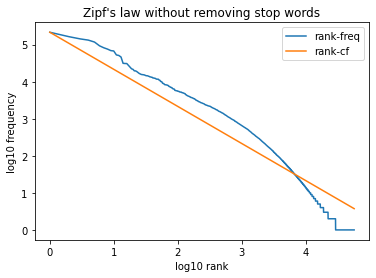

In [106]:
plot_zipf(log_rank,log_freq,log_cf, stop_words_flag=True)

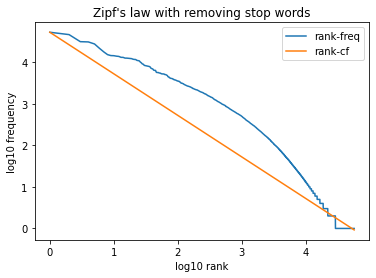

In [107]:
log_rank, log_freq, log_cf = calculate_rfc(positional_index)
plot_zipf(log_rank,log_freq,log_cf, stop_words_flag = False)

### Heaps Law

In [108]:
import numpy as np

In [109]:
def collection_vocab_size(contents, stemming,top_first_doc):
    preprocessed_docs_3 = preprocess(contents[:top_first_doc], True, stemming)
    # collection size -> all of docs word
    collection_size = 0
    for doc in preprocessed_docs_3:
        collection_size += len(doc)
    # unique words 
    vocab_size = len(positional_indexing(preprocessed_docs_3))
    return collection_size,vocab_size

In [110]:
def calculate_m_t(stemming):
  doc_length = [500, 1000, 1500, 2000]
  if stemming:
    print('After stemming:')
  else:
    print('Before stemming')
  return_t, return_m = ([],[])
  for num in doc_length:
    print(f'First {num} Docs')
    T_size, M_size = collection_vocab_size(contents,stemming,num)
    print('vocab size : ', M_size, '  collection size: ', T_size)
    return_t.append(T_size)
    return_m.append(M_size)
  return return_t, return_m

In [111]:
doc_length = [500, 1000, 1500, 2000]

# M = k * (T ^ b)
# M is the size of the vocabulary, T is the number of tokens in the collection

ta, ma = calculate_m_t(True)
print('-----------------------------------')
tb, mb = calculate_m_t(False)


After stemming:
First 500 Docs
vocab size :  7767   collection size:  80287
First 1000 Docs
vocab size :  11351   collection size:  164475
First 1500 Docs
vocab size :  13705   collection size:  248561
First 2000 Docs
vocab size :  15679   collection size:  326937
-----------------------------------
Before stemming
First 500 Docs
vocab size :  10093   collection size:  75476
First 1000 Docs
vocab size :  15082   collection size:  154565
First 1500 Docs
vocab size :  18421   collection size:  233325
First 2000 Docs
vocab size :  21099   collection size:  306798


In [112]:
def plot_heaps(input_m, input_t, stemming):

    log_M = np.log10(input_m)
    log_T = np.log10(input_t)
    plt.plot(log_T, log_M,label='actual')

    # a vector of coefficients p that minimises the squared error in the order of degree
    # Degree of the fitting polynomial
    [b, log_k] = np.polyfit(log_T, log_M, 1)
    plt.plot(log_T, b * log_T + log_k,label='heap')
    if stemming:
      plt.title("Actual value after stemming VS Heaps' Law after stemming")
    else:
      plt.title("Actual value before stemming VS Heaps' Law before stemming")
    plt.legend()
    plt.xlabel('log10 T')
    plt.ylabel('log10 M')
    plt.show()

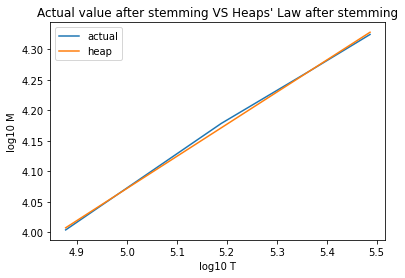

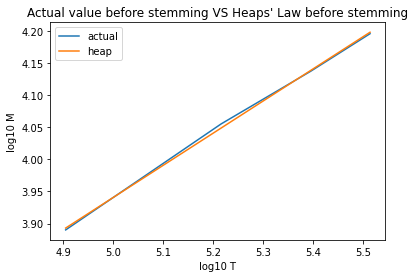

In [113]:
plot_heaps(mb,tb,True)
plot_heaps(ma,ta,False)

### Answering Query

In [114]:
from itertools import permutations
import re

In [115]:
def positional_intersect(pos_dict_1, pos_dict_2, k):

# used when we have phrase queries 
# to find intersection between words of our query based on distance

    doc_ids_1 = list(pos_dict_1.keys())
    doc_ids_2 = list(pos_dict_2.keys())
    doc_ids_1.sort()
    doc_ids_2.sort()

    answer = []
    i, j = 0, 0
    
    while i < len(doc_ids_1) and j < len(doc_ids_2):
        doc_id_1 = doc_ids_1[i]
        doc_id_2 = doc_ids_2[j]

        if doc_id_1 == doc_id_2:
            pos_list_1 = pos_dict_1[doc_id_1]
            pos_list_2 = pos_dict_2[doc_id_2]

            for pos in pos_list_1:
                if pos + k in pos_list_2 or pos - k in pos_list_2:
                    answer.append(doc_id_1)

            i, j = i + 1, j + 1
            
        elif doc_id_1 < doc_id_2:
            i += 1
        else:
            j += 1

    return answer

In [116]:
def process_phrase(tokens):

    result = []
# used when we have more than 2 words in our phrase
# split it to 2 biword index
# aggregate the results
    for biword in permutations(tokens, 2):
        w1 = biword[0]
        w2 = biword[1]
        if (w1 not in positional_index.keys()) or (w2 not in positional_index.keys()):
            return []
        
        indx1 = tokens.index(w1)
        indx2 = tokens.index(w2)
        pos_dic_1 = positional_index.get(w1).pos_in_doc
        pos_dic_2 = positional_index.get(w2).pos_in_doc  
        k = abs(indx1-indx2)

        docs = positional_intersect(pos_dic_1, pos_dic_2, k)
        
        if len(result) == 0:
            result = docs
        else:
            result = list(set(result) & set(docs))

    return result

In [117]:
def process_query(not_words=[], phrases=[], words=[]):
    ranks={}
    
    # find words
    for token in words:
        if token in positional_index.keys():
            for doc_id in positional_index[token].pos_in_doc.keys():
                if doc_id in ranks.keys():
                    ranks[doc_id]+=1
                else:
                    ranks[doc_id]=1
    # find phrases
    for phrase in phrases:
        for doc_id in process_phrase(phrase):
            if doc_id in ranks.keys():
                ranks[doc_id] += 1
            else:
                ranks[doc_id] = 1
    # find ! not words
    not_words_docs = []
    for word in not_words:
        doc_ids = positional_index[word].pos_in_doc.keys()
        for doc_id in doc_ids:
            not_words_docs.append(doc_id)
            
    # from results remove docs which contain not
    if len(ranks) > 0:
        for doc in not_words_docs:
            if doc in ranks.keys():
                del ranks[doc]
                
    ranks = dict(sorted(ranks.items(), key=lambda x: x[1], reverse=True))
    
    return ranks

In [118]:
def not_terms(query):
    splitted_query = query.split()
    indices = [i for i in range(len(splitted_query)) if splitted_query[i]=='!']
    result = [splitted_query[i+1] for i in indices]
    return result

In [119]:
def get_phrase(query):
    res = []
    quoted = re.compile('"[^"]*"')
    for value in quoted.findall(query):
        value = value.replace('"', '').strip().split()
        res.append(value)
    return res

In [120]:
def search_query(query):
    # preprocessed query
    query = ' '.join(preprocess([query], True, True)[0])
    phrases = get_phrase(query)
    flat_phrases = [item for sublist in phrases for item in sublist]
    not_words = not_terms(query)
    query = query.replace('"','')
    query = query.replace('!', '')
    splitted_query = query.split()
    looking_words = []
    for x in splitted_query:
      if x not in not_words and x not in flat_phrases:
        looking_words.append(x)
    output = process_query(not_words=not_words, phrases=phrases, words=looking_words)  
    return output

In [121]:
def print_output(output_dict):
    ids = list(output_dict.keys())[:5]
    for i in range(len(ids)):
        print(f'Rank {i + 1}:')
        title = input_data[str(ids[i])]['title']
        url = input_data[str(ids[i])]['url']
        print('title: ', title, '\nurl: ', url)
        print('------------')

In [122]:
query = 'تحریم‌های آمریکا علیه ایران'
res = search_query(query)
print_output(res)

Rank 1:
title:  خبرگزاری فارس ۱۹ ساله شد 
url:  https://www.farsnews.ir/news/14001122000809/خبرگزاری-فارس-۱۹-ساله-شد
------------
Rank 2:
title:  اصولی: فدراسیون فوتبال جمهوری اسلامی ایران هستیم نه جزیره مستقل/ با گفتار ساختارشکنانه فدراسیون را به ناکجا آباد می‌برند 
url:  https://www.farsnews.ir/news/14001117000518/اصولی-فدراسیون-فوتبال-جمهوری-اسلامی-ایران-هستیم-نه-جزیره-مستقل-با
------------
Rank 3:
title:  احتمال مبادله نازنین زاغری در ازای 530میلیون دلار 
url:  https://www.farsnews.ir/news/14001223001080/احتمال-مبادله-نازنین-زاغری-در-ازای-530میلیون-دلار
------------
Rank 4:
title:  متکی: آمریکا با ابزار ناتو به دنبال تجزیه روسیه است 
url:  https://www.farsnews.ir/news/14001222000749/متکی-آمریکا-با-ابزار-ناتو-به-دنبال-تجزیه-روسیه-است
------------
Rank 5:
title:  توضیحات یک منبع آگاه درباره وقفه مذاکرات وین 
url:  https://www.farsnews.ir/news/14001222000450/توضیحات-یک-منبع-آگاه-درباره-وقفه-مذاکرات-وین
------------


In [123]:
query = 'تحریم‌های آمریکا ! ایران'
res = search_query(query)
print_output(res)

Rank 1:
title:  ادامه تحریم‌های سیاسی علیه المپیک پکن/ژاپن هم به صف منتقدان پیوست 
url:  https://www.farsnews.ir/news/14001003000306/ادامه-تحریم‌های-سیاسی-علیه-المپیک-پکن-ژاپن-هم-به-صف-منتقدان-پیوست
------------
Rank 2:
title:  انتقاد دانشجویان ایرانی در اروپا به برخورد دوگانه مدعیان حقوق بشر با قضایای اوکراین و جنایت‌های آل سعود 
url:  https://www.farsnews.ir/news/14001224000014/انتقاد-دانشجویان-ایرانی-در-اروپا-به-برخورد-دوگانه-مدعیان-حقوق-بشر-با
------------
Rank 3:
title:  محو رژیم صهیونیستی از آرمان‌های نظام اسلامی حذف نشده است 
url:  https://www.farsnews.ir/news/14001222000379/محو-رژیم-صهیونیستی-از-آرمان‌های-نظام-اسلامی-حذف-نشده-است
------------
Rank 4:
title:  تجربه نشان داده به عهد آمریکا در مذاکرات نمی‌شود اعتماد کرد 
url:  https://www.farsnews.ir/news/14001203000366/تجربه-نشان-داده-به-عهد-آمریکا-در-مذاکرات-نمی‌شود-اعتماد-کرد
------------
Rank 5:
title:  سود مافیای اسلحه‌سازی آمریکا در ناامن بودن جهان است 
url:  https://www.farsnews.ir/news/14001211000898/سود-مافیای-اسلحه‌سازی-

In [124]:
query = '"کنگره ضدتروریست"'
res = search_query(query)
print_output(res)

Rank 1:
title:  توضیحات یک منبع آگاه درباره وقفه مذاکرات وین 
url:  https://www.farsnews.ir/news/14001222000450/توضیحات-یک-منبع-آگاه-درباره-وقفه-مذاکرات-وین
------------


In [125]:
query = '"تحریم هسته‌ای" آمریکا ! ایران'
res = search_query(query)
print_output(res)

Rank 1:
title:  بمب خبری بازگشت مسی به بارسلونا خنثی شد/پای جام جهانی درمیان است 
url:  https://www.farsnews.ir/news/14001221000109/بمب-خبری-بازگشت-مسی-به-بارسلونا-خنثی-شد-پای-جام-جهانی-درمیان-است
------------
Rank 2:
title:  منچستریونایتد به دنبال بهترین بازیکن دنیا / زوج «رونالدو - لواندوفسکی» در اولدترافورد +عکس 
url:  https://www.farsnews.ir/news/14001220000373/منچستریونایتد-به-دنبال-بهترین-بازیکن-دنیا--زوج-رونالدو--لواندوفسکی
------------
Rank 3:
title:  راهیابی بانوی سنگنورد کشورمان به مسابقات جهانی آمریکا 
url:  https://www.farsnews.ir/news/14001217000994/راهیابی-بانوی-سنگنورد-کشورمان-به-مسابقات-جهانی-آمریکا
------------
Rank 4:
title:  مدرس جهانی تنیس روی میز: صحبت‌های عیلقارداشی بیشتر شوخی است تا جدی/در همه زمینه‌ها سقوط کردیم 
url:  https://www.farsnews.ir/news/14001214000887/مدرس-جهانی-تنیس-روی-میز-صحبت‌های-عیلقارداشی-بیشتر-شوخی-است-تا-جدی-در
------------
Rank 5:
title:  راجر فدرر از زمان بازگشتش به میادین پرده برداشت 
url:  https://www.farsnews.ir/news/14001214000736/راجر-ف

In [126]:
query = '"تحریم هسته‌ای" ایران ! آمریکا'
res = search_query(query)
print_output(res)

Rank 1:
title:  ۹ دی یکی از روزهای فراموش نشدنی در تاریخ انقلاب اسلامی است 
url:  https://www.farsnews.ir/news/14001007000363/۹-دی-یکی-از-روزهای-فراموش-نشدنی-در-تاریخ-انقلاب-اسلامی-است
------------
Rank 2:
title:  اعلام زمان قرعه کشی جام باشگاه های فوتسال آسیا 
url:  https://www.farsnews.ir/news/14001224001005/اعلام-زمان-قرعه-کشی-جام-باشگاه-های-فوتسال-آسیا
------------
Rank 3:
title:  محل برگزاری نشست‌های خبری سرخابی‌ها؛ مجیدی در سازمان لیگ، گل‌محمدی در تمرین پرسپولیس 
url:  https://www.farsnews.ir/news/14001224000971/محل-برگزاری-نشست‌های-خبری-سرخابی‌ها-مجیدی-در-سازمان-لیگ-گل‌محمدی-در
------------
Rank 4:
title:  ماجدی در نشست با صالحی امیری: امیدوارم در این دوره تیم  المپیک موفق شود 
url:  https://www.farsnews.ir/news/14001224000964/ماجدی-در-نشست-با-صالحی-امیری-امیدوارم-در-این-دوره-تیم-المپیک-موفق
------------
Rank 5:
title:  مسابقات تنیس روی میز فیدر قطر| هر4 بانوی ملی پوش ایران حذف شدند 
url:  https://www.farsnews.ir/news/14001224000916/مسابقات-تنیس-روی-میز-فیدر-قطر|-هر4-بانوی-ملی-پ

In [127]:
query = 'غزه ! ضدتروریست'
res = search_query(query)
print_output(res)

Rank 1:
title:  سفر تیم فوتبال معلولان فلسطین به تهران 
url:  https://www.farsnews.ir/news/14001212000749/سفر-تیم-فوتبال-معلولان-فلسطین-به-تهران
------------
Rank 2:
title:  بیانیه بسیج ورزشکاران در محکومیت اقدام شرم‌آور سرمربی تیم ملی امید 
url:  https://www.farsnews.ir/news/14000929000204/بیانیه-بسیج-ورزشکاران-در-محکومیت-اقدام-شرم‌آور-سرمربی-تیم-ملی-امید
------------
Rank 3:
title:  اقدام تحسین برانگیز سرمربی الجزایر در حمایت از فلسطین/جام قهرمانی به مردم غزه اهدا شد 
url:  https://www.farsnews.ir/news/14000928000274/اقدام-تحسین-برانگیز-سرمربی-الجزایر-در-حمایت-از-فلسطین-جام-قهرمانی-به
------------
Rank 4:
title:  اردوغان علاوه بر آرمان فلسطین بر باورهای مردم ترکیه هم پا گذاشت 
url:  https://www.farsnews.ir/news/14001220000842/اردوغان-علاوه-بر-آرمان-فلسطین-بر-باورهای-مردم-ترکیه-هم-پا-گذاشت
------------
Rank 5:
title:  نگاه دوگانه برخی جریان‌ها به یمن و اوکراین نشانه سرسپردگی‌شان به آمریکاست 
url:  https://www.farsnews.ir/news/14001209000540/نگاه-دوگانه-برخی-جریان‌ها-به-یمن-و-اوکراین-ن

In [128]:
query = 'تیم ملی فوتبال'
res = search_query(query)
print_output(res)

Rank 1:
title:  ماجدی در نشست با صالحی امیری: امیدوارم در این دوره تیم  المپیک موفق شود 
url:  https://www.farsnews.ir/news/14001224000964/ماجدی-در-نشست-با-صالحی-امیری-امیدوارم-در-این-دوره-تیم-المپیک-موفق
------------
Rank 2:
title:  مدیرعامل آلومینیوم: مرفاوی می‌داند هیچ باشگاهی با یک نفر صحبت نمی‌کند/استقلالی‌ها لیگ را گرفته‌اند 
url:  https://www.farsnews.ir/news/14001224000282/مدیرعامل-آلومینیوم-مرفاوی-می‌داند-هیچ-باشگاهی-با-یک-نفر-صحبت-نمی‌کند
------------
Rank 3:
title:  درخواست مدیر فوتبال کره جنوبی از مردم ؛ بیایید با هم ایران را شکست دهیم 
url:  https://www.farsnews.ir/news/14001224000208/درخواست-مدیر-فوتبال-کره-جنوبی-از-مردم-بیایید-با-هم-ایران-را-شکست-دهیم
------------
Rank 4:
title:  ورزشگاه سئول پر از تماشاگر/ دیدار ایران و کره جنوبی با 65 هزار تماشاگر 
url:  https://www.farsnews.ir/news/14001224000189/ورزشگاه-سئول-پر-از-تماشاگر-دیدار-ایران-و-کره-جنوبی-با-65-هزار-تماشاگر
------------
Rank 5:
title:  برگزاری نخستین جلسه کمیته المپیک با تیم امید فوتبال 
url:  https://www.fars

In [129]:
query = 'واکسن کرونا ایرانی'
res = search_query(query)
print_output(res)

Rank 1:
title:  شروط حضور هواداران در تمام ورزشگاه‌های کشور/ مهدی: تغییر زمان دربی نهایی نشده است 
url:  https://www.farsnews.ir/news/14001217000675/شروط-حضور-هواداران-در-تمام-ورزشگاه‌های-کشور-مهدی-تغییر-زمان-دربی
------------
Rank 2:
title:  نحوه توزیع سکوهای آزادی برای تماشاگران در دیدار ایران-عراق از زبان خبرنگار عراقی 
url:  https://www.farsnews.ir/news/14001106000376/نحوه-توزیع-سکوهای-آزادی-برای-تماشاگران-در-دیدار-ایران-عراق-از-زبان
------------
Rank 3:
title:  وزیر کشور: ممکن است دوز سوم واکسن برای سفرهای خارجی اجباری شود 
url:  https://www.farsnews.ir/news/14001217000520/وزیر-کشور-ممکن-است-دوز-سوم-واکسن-برای-سفرهای-خارجی-اجباری-شود
------------
Rank 4:
title:  سخنگوی دولت: ۹۹ درصد سواحلی که در اختیار نهادهای دولتی بود آزاد شد 
url:  https://www.farsnews.ir/news/14001212000835/سخنگوی-دولت-۹۹-درصد-سواحلی-که-در-اختیار-نهادهای-دولتی-بود-آزاد-شد
------------
Rank 5:
title:  همایش علمی دانشگاهیان ایرانی خارج کشور| حمایت فارغ‌التحصیلان ایرانی دانشگاه‌های برتر دنیا برای بازگشت به کشور 


# PHASE 2

In [130]:
import math
import numpy as np

In [131]:
def calculate_tf_for_query(term, tokens):
    freq = 0
    for token in tokens:
        if token == term:
            freq += 1
    if freq > 0:
        return 1 + math.log10(freq)
    return 0

In [132]:
def calculate_tf(term, doc_id):
    freq = term.freq_in_doc[doc_id]
    if freq > 0:  
        return 1 + math.log10(freq)
    return 0

In [133]:
def calculate_idf(term, collection_size):
  n = len (term.freq_in_doc)
  return math.log10(collection_size/n)

In [134]:
def calculate_tf_idf(term, doc_id, collection_size):
  return calculate_tf(term, doc_id) * calculate_idf(term, collection_size)

In [135]:
def calculate_weights(dictionary, collection_size):
  for term in dictionary:
    postings_list = dictionary[term].get_docs()
    for doc_id in postings_list:
        dictionary[term].calc_weight(doc_id, collection_size)    

In [136]:
calculate_weights(positional_index, len(contents))

In [137]:
positional_index['فوتبال'].pos_in_doc

{0: [4, 10],
 1: [27, 34],
 2: [34],
 3: [17, 38, 64, 75, 97, 119, 145],
 7: [8],
 9: [35],
 12: [6, 48],
 15: [6],
 16: [6, 14],
 23: [31, 67],
 29: [13, 209],
 33: [4, 9, 25, 43],
 35: [4, 32],
 36: [15, 27],
 37: [6, 15],
 40: [101],
 42: [34],
 45: [22],
 48: [303],
 53: [56, 200, 235, 246, 282, 283, 419],
 63: [34],
 64: [75],
 66: [12, 37, 90, 184, 213],
 69: [8, 34],
 74: [9],
 76: [57],
 79: [18],
 80: [9, 35, 85],
 81: [11, 45, 46, 73, 86, 96, 99, 104, 115, 119, 134, 141, 164],
 82: [15],
 84: [37],
 85: [11, 26, 70, 89, 139, 183, 248, 355, 367],
 86: [210, 553],
 87: [5, 49],
 88: [12],
 89: [10, 110, 207, 264, 282, 328, 397, 401, 410, 420],
 90: [4],
 91: [273],
 94: [10],
 95: [47],
 96: [16, 31, 48],
 97: [5],
 102: [10],
 103: [4],
 104: [104],
 107: [8],
 109: [9],
 112: [40],
 113: [8],
 115: [8],
 120: [23, 31, 51, 73],
 123: [10],
 127: [4, 13, 26],
 128: [124],
 129: [30, 31, 54, 58, 72, 91, 112, 117, 122],
 134: [33, 98, 104, 116, 125, 130, 147, 161],
 136: [7, 27, 

In [138]:
positional_index['فوتبال'].weight_in_doc

{0: 0.7366556536239535,
 1: 0.7366556536239535,
 2: 0.5662095847744086,
 3: 1.0447121951045477,
 7: 0.5662095847744086,
 9: 0.5662095847744086,
 12: 0.7366556536239535,
 15: 0.5662095847744086,
 16: 0.7366556536239535,
 23: 0.7366556536239535,
 29: 0.7366556536239535,
 33: 0.9071017224734984,
 35: 0.7366556536239535,
 36: 0.7366556536239535,
 37: 0.7366556536239535,
 40: 0.5662095847744086,
 42: 0.5662095847744086,
 45: 0.5662095847744086,
 48: 0.5662095847744086,
 53: 1.0447121951045477,
 63: 0.5662095847744086,
 64: 0.5662095847744086,
 66: 0.9619731006992724,
 69: 0.7366556536239535,
 74: 0.5662095847744086,
 76: 0.5662095847744086,
 79: 0.5662095847744086,
 80: 0.8363602122962736,
 81: 1.1969349877462756,
 82: 0.5662095847744086,
 84: 0.5662095847744086,
 85: 1.1065108398181385,
 86: 0.7366556536239535,
 87: 0.7366556536239535,
 88: 0.5662095847744086,
 89: 1.1324191695488173,
 90: 0.5662095847744086,
 91: 0.5662095847744086,
 94: 0.5662095847744086,
 95: 0.5662095847744086,
 96: 0

In [139]:
def champions_list(dictionary, r):
    for term in dictionary:
        dictionary[term].create_champ_list(r)

In [140]:
champions_list(positional_index, 50)

In [141]:
positional_index['فوتبال'].get_champ_list()

{3457: 1.5425111089376038,
 4918: 1.473311307247907,
 2098: 1.4404757110294113,
 163: 1.418439929022133,
 6323: 1.4025697970706823,
 1950: 1.337232937381684,
 5268: 1.3263021734744984,
 5395: 1.3263021734744984,
 6128: 1.3148628226264127,
 1322: 1.302865238398362,
 2286: 1.2902521301986898,
 2287: 1.2902521301986898,
 2788: 1.2902521301986898,
 6350: 1.2902521301986898,
 2626: 1.2769569086676833,
 536: 1.2629015576341203,
 2109: 1.2629015576341203,
 5252: 1.2629015576341203,
 5303: 1.2629015576341203,
 5353: 1.2629015576341203,
 6327: 1.2629015576341203,
 6673: 1.2629015576341203,
 1643: 1.2479938601725882,
 4926: 1.2479938601725882,
 5102: 1.2479938601725882,
 1276: 1.2321237282211375,
 1572: 1.2321237282211375,
 2391: 1.2321237282211375,
 3057: 1.2321237282211375,
 3109: 1.2321237282211375,
 4962: 1.2321237282211375,
 5583: 1.2321237282211375,
 5991: 1.2321237282211375,
 6069: 1.2321237282211375,
 142: 1.2151582639540925,
 246: 1.2151582639540925,
 860: 1.2151582639540925,
 1974: 1.2

In [142]:
def get_docs_norm(dictionary, collection_size):
    lengths = np.zeros(collection_size)
    for term in dictionary:
        for doc_id, weight in dictionary[term].weight_in_doc.items():
            lengths[int(doc_id)] += weight ** 2
    return np.sqrt(lengths)

In [143]:
docs_norms = get_docs_norm(positional_index, len(contents))
print(docs_norms)

[10.33726671  7.70131393  7.14326871 ... 16.20218927 18.79565458
  8.16871913]


In [144]:
def cosine_similarity(query_tokens, dictionary, collection_size, norms):
  scores = {}
  for term in query_tokens:
    w_t_q = calculate_tf_for_query(term, query_tokens) * calculate_idf(dictionary[term], collection_size)
    for doc_id, w_t_d in dictionary[term].get_champ_list().items():
      if doc_id not in scores:
        scores[doc_id] = 0
      scores[doc_id] += w_t_q * w_t_d 
      
  for doc_id in scores:
    scores[doc_id] /= norms[int(doc_id)]
  return scores

In [145]:
def print_result(socres, k):
    sorted_scores = dict(sorted(socres.items(), key=lambda item: item[1],reverse=True)[:k])
    for doc_id in sorted_scores:
        title = input_data[str(doc_id)]['title']
        url = input_data[str(doc_id)]['url']
        print(doc_id, 'title: ', title, '\nurl: ', url)
        print('------------')

In [146]:
query = 'فوتبال'
query_tokens = preprocess([query], True, True)[0]
scores = cosine_similarity(query_tokens, positional_index, len(contents), docs_norms)
print_result(scores, k=5)

1466 title:  نکونام: نفتی ها بهترین بازی خود را انجام دادند/بازیکنان جدیدمان کیفیت بالای خود را نشان دادند 
url:  https://www.farsnews.ir/news/14001204001165/نکونام-نفتی-ها-بهترین-بازی-خود-را-انجام-دادند-بازیکنان-جدیدمان-کیفیت
------------
81 title:  ماجدی: فوتبال کشور به تغییرات نیاز دارد 
url:  https://www.farsnews.ir/news/14001223000539/ماجدی-فوتبال-کشور-به-تغییرات-نیاز-دارد
------------
6690 title:  امیدواری ملی پوش سابق فوتبال ساحلی بابت تغییرات در کادرفنی تیم ملی 
url:  https://www.farsnews.ir/news/14000927000275/امیدواری-ملی-پوش-سابق-فوتبال-ساحلی-بابت-تغییرات-در-کادرفنی-تیم-ملی
------------
139 title:  تقدیر مربی تیم فوتبال خلیج فارس از ماجدی بابت رسیدگی به شائبه تبانی در لیگ جوانان 
url:  https://www.farsnews.ir/news/14001222000297/تقدیر-مربی-تیم-فوتبال-خلیج-فارس-از-ماجدی-بابت-رسیدگی-به-شائبه-تبانی-در
------------
860 title:  دیدار مدیر تیم ملی ایران با سفیر کره جنوبی/ هیان: امیدوارم مقابل ایران مساوی کنیم 
url:  https://www.farsnews.ir/news/14001213000138/دیدار-مدیر-تیم-ملی-ای

In [147]:
query = 'تیم ملی فوتبال'
query_tokens = preprocess([query], True, True)[0]
scores = cosine_similarity(query_tokens, positional_index, len(contents), docs_norms)
print_result(scores, k=5)

142 title:  اسکوچیچ: مردم متوجه شده‌اند که می‌توانند هدایت تیم ملی را به من واگذار کنند/هاشمیان سواد اروپایی از فوتبال دارد 
url:  https://www.farsnews.ir/news/14001222000329/اسکوچیچ-مردم-متوجه-شده‌اند-که-می‌توانند-هدایت-تیم-ملی-را-به-من-واگذار
------------
2098 title:  مصاحبه فارس با کارشناس فوتبال آسیا| از میراث بزرگ کی‌روش و قدرت ایران با اسکوچیچ تا انقلاب برانکو در عمان 
url:  https://www.farsnews.ir/news/14001124000522/مصاحبه-فارس-با-کارشناس-فوتبال-آسیا|-از-میراث-بزرگ-کی‌روش-و-قدرت-ایران
------------
1466 title:  نکونام: نفتی ها بهترین بازی خود را انجام دادند/بازیکنان جدیدمان کیفیت بالای خود را نشان دادند 
url:  https://www.farsnews.ir/news/14001204001165/نکونام-نفتی-ها-بهترین-بازی-خود-را-انجام-دادند-بازیکنان-جدیدمان-کیفیت
------------
81 title:  ماجدی: فوتبال کشور به تغییرات نیاز دارد 
url:  https://www.farsnews.ir/news/14001223000539/ماجدی-فوتبال-کشور-به-تغییرات-نیاز-دارد
------------
6690 title:  امیدواری ملی پوش سابق فوتبال ساحلی بابت تغییرات در کادرفنی تیم ملی 
url:  https://

In [148]:
query = 'واترپلو'
query_tokens = preprocess([query], True, True)[0]
scores = cosine_similarity(query_tokens, positional_index, len(contents), docs_norms)
print_result(scores, k=5)


1388 title:  تجلیل از خانواده شهید حسن نوفلاح با تقدیم مدال قهرمانی 
url:  https://www.farsnews.ir/news/14001205000938/تجلیل-از-خانواده-شهید-حسن-نوفلاح-با-تقدیم-مدال-قهرمانی
------------
5690 title:  سرپرست  فدراسیون شنا، شیرجه و واترپلو  منصوب شد 
url:  https://www.farsnews.ir/news/14001011000202/سرپرست-فدراسیون-شنا-شیرجه-و-واترپلو-منصوب-شد
------------
5022 title:  رضوانی رئیس فدراسیون شنا ماند/ 3 رای سفید برای تنها کاندیدا 
url:  https://www.farsnews.ir/news/14001020000253/رضوانی-رئیس-فدراسیون-شنا-ماند-3-رای-سفید-برای-تنها-کاندیدا
------------
5013 title:  برنامه‌های رئیس فدراسیون شنا برای 4 سال آینده/ رضوانی: تلاش می‌کنیم به اهداف‌مان در بازی‌های آسیایی برسیم 
url:  https://www.farsnews.ir/news/14001020000394/برنامه‌های-رئیس-فدراسیون-شنا-برای-4-سال-آینده-رضوانی-تلاش-می‌کنیم-به
------------
1300 title:  گرفتن ۷۰ نمونه تست دوپینگ در ۸ رشته طی یک هفته 
url:  https://www.farsnews.ir/news/14001207000351/گرفتن-۷۰-نمونه-تست-دوپینگ-در-۸-رشته-طی-یک-هفته
------------


In [149]:
query = 'واکسن کرونا ایرانی'
query_tokens = preprocess([query], True, True)[0]
scores = cosine_similarity(query_tokens, positional_index, len(contents), docs_norms)
print_result(scores, k=5)

7937 title:  مرندی: رهبر انقلاب دُز سوم واکسن کرونا را دریافت کرده‌اند 
url:  https://www.farsnews.ir/news/14001117000930/مرندی-رهبر-انقلاب-دُز-سوم-واکسن-کرونا-را-دریافت-کرده‌اند
------------
11966 title:  الهیان: وزارت بهداشت درباره علت عدم پیش خرید واکسن فخرا توضیح دهد 
url:  https://www.farsnews.ir/news/14000729000462/الهیان-وزارت-بهداشت-درباره-علت-عدم-پیش-خرید-واکسن-فخرا-توضیح-دهد
------------
7228 title:  رئیسی: مسافرت با رعایت اصول بهداشتی بلااشکال است 
url:  https://www.farsnews.ir/news/14001214000475/رئیسی-مسافرت-با-رعایت-اصول-بهداشتی-بلااشکال-است
------------
9835 title:  نایب رئیس مجلس: دولت در تزریق واکسن و کاهش نگرانی‌‌های مردم شاهکار کرده است 
url:  https://www.farsnews.ir/news/14000923000300/نایب-رئیس-مجلس-دولت-در-تزریق-واکسن-و-کاهش-نگرانی‌‌های-مردم-شاهکار
------------
9736 title:  تأکید مخبر بر حمایت از تولیدکنندگان داخلی واکسن کرونا 
url:  https://www.farsnews.ir/news/14000924000889/تأکید-مخبر-بر-حمایت-از-تولیدکنندگان-داخلی-واکسن-کرونا
------------
